<img src="../notebooks/resources/ICESI.png">

# Evaluación del modelo Inception V3

Para realizar predicción de Glaucoma a partir de diferentes bases de datos de imágenes públicas: ORIGA, REFUGE y G1020.

InceptionV3 es una arquitectura de red neuronal convolucional profunda desarrollada por Google, diseñada para tareas de clasificación de imágenes. Es la tercera versión de la serie Inception (GoogLeNet) y fue presentada en el artículo “Rethinking the Inception Architecture for Computer Vision” (2015).


# 0. Librerías necesarias

In [76]:
import warnings 
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import os
from glob import glob
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy import ndimage
import cv2
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                            precision_score, recall_score, f1_score, roc_curve, auc)

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# 1. Análisis Exploratorio y carga de datos

## Descripción de las bases de datos:

1. ORIGA(-light) contiene 650 imágenes retinianas anotadas por profesionales formados del Instituto de Investigación Ocular de Singapur.

    La base de datos está compuesta por un conjunto de imágenes y un archivo en formato CSV que contiene las columnas que se aprecian a continuación:

    Las  columnas (Image, CDR, Ecc-Cup, Ecc-Disc)  corresponden a variables explicativas y la última (Glaucoma) corresponde a nuestra variable clasificatoria.

    Cada una de estas columnas se explica de la siguiente manera:


    - Image: Nombre de archivo de imagen.
    - Source: Fuente del dato
    - CDR: Cup-to-Disc Ratio. Proporción entre el diámetro del "cup" (excavación central) y el disco óptico. Valor clave en la detección de glaucoma..
    - Ecc-Cup: Excentricidad de la región de excavación del nervio óptico (cup). Una medida morfológica.
    - Ecc-Disc: Excentricidad del disco óptico completo. Ayuda a describir la forma del disco.
    - Glaucoma: Variable clasificatoria que identifica el diagnóstico negativo (0) o positivo (1) del glaucoma

2. G1020 esta base de datos consta de 1020 imágenes de fondo de ojo en color de alta resolución y proporciona anotaciones de la verdad fundamental para el diagnóstico del glaucoma.

    La base de datos está compuesta por un conjunto de imágenes y un archivo en formato CSV en donde se encuentra el label de la variable predictora (Glaucoma).

3. REFUGE (Retinal Fundus Glaucoma Challenge) es una base de datos pública creada para fomentar el desarrollo de algoritmos de inteligencia artificial en la detección automática de glaucoma a partir de imágenes de fondo de ojo (retinografías). Contiene 1200 imágenes de fondo de ojo (color fundus images) de alta calidad, provenientes de los centros clínicos Zhongshan Ophthalmic Center (ZOC) y Beijing Tongren Hospital (TR).

### Bases de datos públicas utilizadas para detección de Glaucoma

| Dataset  | Nº de Imágenes | Resolución | Anotaciones Disponibles | Etiqueta de Glaucoma | Fuente | Acceso |
|----------|----------------|------------|--------------------------|----------------------|--------|--------|
| **REFUGE** | 1200 | ~2124×2056 px | Segmentación de disco y copa óptica | ✅ | Zhongshan Ophthalmic Center, Beijing Tongren Hospital | [refuge.grand-challenge.org](https://refuge.grand-challenge.org/) |
| **ORIGA**  | 650  | 3072×2048 px   | Segmentación + CDR + labels | ✅ | Singapore Eye Research Institute | [Kaggle](https://www.kaggle.com/datasets/arnavjain1/glaucoma-datasets?select=ORIGA) |
| **G1020**  | 1020 | 2124×2056 px   | Segmentación + medidas clínicas (CDR, VCDR, etc.) | ✅ | MESSIDOR + anotación médica posterior | [G1020 en Zenodo](https://zenodo.org/record/6333984) |



## Carga de los datos

In [ ]:
df_g1020 = pd.read_csv("./datos/G1020/G1020.csv")
df_origa = pd.read_csv("./datos/ORIGA/origa_info.csv")
df_refuge_train = pd.read_json("./datos/REFUGE/train/index.json", orient='index')
df_refuge_test = pd.read_json("./datos/REFUGE/test/index.json", orient='index') ## esta no tiene label

### **G1020**

In [49]:
df_g1020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   imageID       1020 non-null   object
 1   binaryLabels  1020 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 16.1+ KB


### **ORIGA**

In [64]:
df_origa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Image     650 non-null    object 
 1   Source    650 non-null    object 
 2   Cropped   650 non-null    bool   
 3   CDR       650 non-null    float64
 4   Ecc-Cup   650 non-null    float64
 5   Ecc-Disc  650 non-null    float64
 6   Label     650 non-null    int64  
dtypes: bool(1), float64(3), int64(1), object(2)
memory usage: 31.2+ KB


### **REFUGE**

In [63]:
df_refuge_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 0 to 399
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ImgName  400 non-null    object 
 1   Fovea_X  400 non-null    float64
 2   Fovea_Y  400 non-null    float64
 3   Size_X   400 non-null    int64  
 4   Size_Y   400 non-null    int64  
 5   Label    400 non-null    int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 21.9+ KB


### **Unificación de los datos**

In [65]:
#Identifico la base
df_origa['Source'] = 'ORIGA'
df_g1020['Source'] = 'G1020'
df_refuge_train['Source'] = 'REFUGE' 

#Renombro columnas
df_g1020 = df_g1020.rename(columns={'imageID': 'Image','binaryLabels': 'Glaucoma'})
df_origa = df_origa.rename(columns={'Label': 'Glaucoma'})
df_refuge_train = df_refuge_train.rename(columns={'ImgName': 'Image','Label': 'Glaucoma'})

#Uno las bases
df_glaucoma = pd.concat([df_origa[['Image', 'Source', 'Glaucoma']]
                      ,df_g1020[['Image', 'Source', 'Glaucoma']]
                      ,df_refuge_train[['Image', 'Source', 'Glaucoma']]
                      ],
                      ignore_index=True)


conteo = df_glaucoma.groupby('Source').size().reset_index(name='Cantidad')
print(conteo)

df_glaucoma.head

   Source  Cantidad
0   G1020      1020
1   ORIGA       650
2  REFUGE       400


<bound method NDFrame.head of           Image  Source  Glaucoma
0       001.jpg   ORIGA         0
1       002.jpg   ORIGA         0
2       003.jpg   ORIGA         0
3       004.jpg   ORIGA         0
4       005.jpg   ORIGA         0
...         ...     ...       ...
2065  n0356.jpg  REFUGE         0
2066  n0357.jpg  REFUGE         0
2067  n0358.jpg  REFUGE         0
2068  n0359.jpg  REFUGE         0
2069  n0360.jpg  REFUGE         0

[2070 rows x 3 columns]>

Revisamos la proporción de la variable objetivo:

In [66]:
labels_counts = df_glaucoma["Glaucoma"].value_counts()
labels_counts

Glaucoma
0    1566
1     504
Name: count, dtype: int64

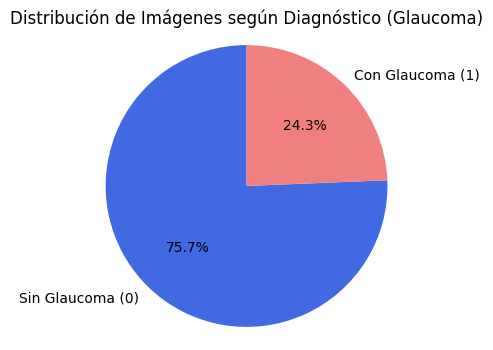

In [67]:
plt.figure(figsize=(4, 4))
plt.pie(labels_counts, 
        labels=['Sin Glaucoma (0)', 'Con Glaucoma (1)'],
        autopct='%1.1f%%',
        colors=['royalblue', 'lightcoral'],
        startangle=90)
plt.title('Distribución de Imágenes según Diagnóstico (Glaucoma)')
plt.axis('equal')  # Para que sea un círculo perfecto
plt.show()



Agregamos la ruta completa de la imagen al dataset

In [68]:

# Rutas diferentes para cada base de datos
root_origa = "./datos/ORIGA/Images"
root_g1020 = "./datos/G1020/Images"
root_refuge = "./datos/REFUGE/train/Images"


# Función para aplicar la ruta correcta
def get_image_path(row):
    if row['Source'] == 'ORIGA':
        return os.path.join(root_origa, row['Image'])
    elif row['Source'] == 'G1020':
        return os.path.join(root_g1020, row['Image'])
    elif row['Source'] == 'REFUGE':
        return os.path.join(root_refuge, row['Image'])
    elif row['Source'] == 'ICESI':
        return row['Image']
    else:
        return None  # En caso de que no coincida con ninguna base

# Aplicar la función a cada fila para crear la columna 'Path'
df_glaucoma['Path'] = df_glaucoma.apply(get_image_path, axis=1)

# Verificar los resultados

df_glaucoma[df_glaucoma["Source"] == "REFUGE"].head()

,Image,Source,Glaucoma,Path
1670,g0001.jpg,REFUGE,1,./datos/REFUGE/train/Images/g0001.jpg
1671,g0002.jpg,REFUGE,1,./datos/REFUGE/train/Images/g0002.jpg
1672,g0003.jpg,REFUGE,1,./datos/REFUGE/train/Images/g0003.jpg
1673,g0004.jpg,REFUGE,1,./datos/REFUGE/train/Images/g0004.jpg
1674,g0005.jpg,REFUGE,1,./datos/REFUGE/train/Images/g0005.jpg


In [69]:
df_glaucoma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2070 entries, 0 to 2069
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Image     2070 non-null   object
 1   Source    2070 non-null   object
 2   Glaucoma  2070 non-null   int64 
 3   Path      2070 non-null   object
dtypes: int64(1), object(3)
memory usage: 64.8+ KB


# 3. Modelo

Parámetros (configuración) del modelo:

In [77]:
# --- Configuración del modelo InceptionV3 ---
IMG_WIDTH, IMG_HEIGHT = 299, 299  # Dimensiones de entrada para InceptionV3

# --- Parámetros de entrenamiento ---
BATCH_SIZE = 16
EPOCHS = 30
LEARNING_RATE = 1e-4

Se cargaron 2070 imágenes y 2070 etiquetas.
Etiquetas únicas encontradas: (array([0, 1]), array([1566,  504]))


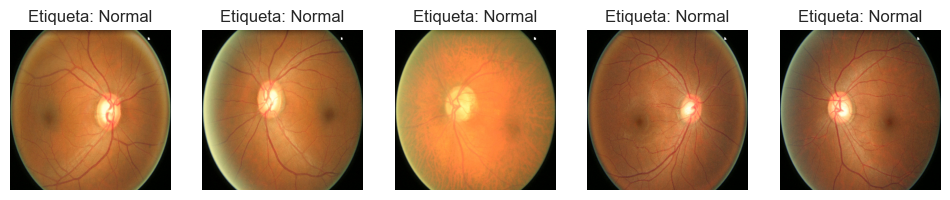

In [91]:
try:
    all_image_paths = df_glaucoma["Path"].values
    all_labels = df_glaucoma["Glaucoma"].values
    
    print(f"Se cargaron {len(all_image_paths)} imágenes y {len(all_labels)} etiquetas.")
    print(f"Etiquetas únicas encontradas: {np.unique(all_labels, return_counts=True)}")

    # Visualización de algunas imágenes y sus etiquetas
    plt.figure(figsize=(12, 6))
    for i in range(min(5, len(all_image_paths))):
        plt.subplot(1, 5, i + 1)
        img = load_img(all_image_paths[i], target_size=(IMG_WIDTH, IMG_HEIGHT))
        plt.imshow(img)
        plt.title(f"Etiqueta: {'Glaucoma' if all_labels[i] == 1 else 'Normal'}")
        plt.axis("off")
    plt.show()

except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Por favor asegúrese de que ORIGA_IMAGES_DIR y ORIGA_GLAUCOMA_LABELS_TXT estén configurados correctamente.")
    all_image_paths, all_labels = [], [] # Evitar errores posteriores

if not all_image_paths.any() or not all_labels.any():
    print("No se encontraron rutas de imágenes o etiquetas. Por favor revise el proceso de carga de datos.")
    print("Esto puede deberse a archivos de datos faltantes o mal especificados.")
    print("Saliendo del script.")
    exit()

In [ ]:
# --- Dividir los datos en conjuntos de entrenamiento y validación ---

train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_image_paths, all_labels,
    test_size=0.2,  # 20% para validación
    random_state=42,
    stratify=all_labels # Importante para datasets desbalanceados
)

In [97]:
print(f"Datos de entrenamiento: {len(train_paths)}, Datos de validación: {len(val_paths)}")
print(f"Distribución de etiquetas en entrenamiento: {np.unique(train_labels, return_counts=True)}")
print(f"Distribución de etiquetas en validación: {np.unique(val_labels, return_counts=True)}")


Datos de entrenamiento: 1656, Datos de validación: 414
Distribución de etiquetas en entrenamiento: (array([0, 1]), array([1253,  403]))
Distribución de etiquetas en validación: (array([0, 1]), array([313, 101]))


In [99]:
def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = preprocess_input(image) # InceptionV3 specific preprocessing
    return image, label

In [101]:
# Aumentación de datos para mejorar la generalización del modelo
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1), # 0.25*2pi = 90 grados de rotación, para evitar que las imágenes se distorsionen demasiado
    # keras.layers.RandomZoom(0.1),
    # keras.layers.RandomContrast(0.1), # Be careful with contrast for medical images
    # keras.layers.RandomBrightness(0.1),
])

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = (
    train_ds
    .shuffle(buffer_size=len(train_paths))
    .map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE) # Aplicar data augmentation
    .prefetch(buffer_size=AUTOTUNE)
)

In [105]:
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = (
    val_ds
    .map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=AUTOTUNE)
)

In [113]:
# --- Verificar las formas de salida del dataset ---
for images, labels in train_ds.take(1):
    print("Forma de las imágenes:", images.shape)  # (BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, 3)
    print("Forma de las etiquetas:", labels.shape)  # (BATCH_SIZE,)

Forma de las imágenes: (16, 299, 299, 3)
Forma de las etiquetas: (16,)


In [ ]:
# Cargar el modelo InceptionV3 pre-entrenado sin las capas superiores
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

In [115]:
# Las capas del modelo base no se entrenarán inicialmente (para evitar sobreajuste y acelerar el entrenamiento)
base_model.trainable = False

In [120]:
# Definimos la entrada del modelo con el tamaño requerido por InceptionV3
inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Pasamos la imagen por la red base (InceptionV3) en modo inferencia (sin actualizar sus pesos)
x = base_model(inputs, training=False)

# Realizamos un pooling global para reducir la dimensionalidad y obtener un vector por imagen
x = GlobalAveragePooling2D()(x)

# Añadimos una capa Dropout para reducir el sobreajuste (regularización)
x = Dropout(0.5)(x)

# Capa densa intermedia para aprender combinaciones no lineales de las características extraídas
x = Dense(256, activation='relu')(x)

# Otro Dropout para mayor regularización
x = Dropout(0.3)(x)

# Capa de salida: una sola neurona con activación sigmoide para clasificación binaria (Glaucoma sí/no)
outputs = Dense(1, activation='sigmoid')(x)

# Definimos el modelo final conectando las entradas con las salidas
model = Model(inputs, outputs)

# --- Compilación del modelo ---
# Optimizador Adam, función de pérdida binaria y métricas de precisión y AUC para evaluar el desempeño
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Mostramos un resumen de la arquitectura del modelo
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,327,585 (85.17 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [122]:
# Guardar el mejor modelo
checkpoint_filepath = 'best_glaucoma_inceptionv3_model.keras' # Usar extensión .keras
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_auc', # O 'val_accuracy' o 'val_loss'
    mode='max', # Para 'val_auc' o 'val_accuracy', usar 'min' para 'val_loss'
    save_best_only=True)

# Detener entrenamiento si no hay mejora en la métrica de validación (Early stopping)
early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor='val_auc', # O 'val_loss'
    patience=10,        # Número de épocas sin mejora antes de detener el entrenamiento
    mode='max',         # Para AUC/accuracy, 'min' para loss
    restore_best_weights=True # Restaura los pesos del modelo de la época con el mejor valor monitoreado
)


In [124]:
# Calcular pesos de clase para el dataset:
# En este caso, como vimos previamente, el dataset se encuentra desbalanceado.
# Los pesos de clase ayudan a que el modelo preste más atención a la clase minoritaria.

counts = np.bincount(all_labels)
weight_for_0 = (1 / counts[0]) * (len(all_labels) / 2.0) if counts[0] > 0 else 0
weight_for_1 = (1 / counts[1]) * (len(all_labels) / 2.0) if counts[1] > 0 else 0
class_weight = {0: weight_for_0, 1: weight_for_1}
print(f"Pesos de clase: {class_weight}")

Pesos de clase: {0: np.float64(0.6609195402298851), 1: np.float64(2.0535714285714284)}


In [125]:
# --- Entrenar el modelo ---
print("Iniciando el entrenamiento...")
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[model_checkpoint_callback, early_stopping_callback],
    class_weight=class_weight # Uso de los pesos de clase
)
print("Entrenamiento finalizado.")

Iniciando el entrenamiento...
Epoch 1/30


104/104 ━━━━━━━━━━━━━━━━━━━━ 60s 552ms/step - accuracy: 0.5132 - auc: 0.5266 - loss: 0.7610 - val_accuracy: 0.4976 - val_auc: 0.6481 - val_loss: 0.7239
Epoch 2/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 58s 554ms/step - accuracy: 0.5839 - auc: 0.5777 - loss: 0.7073 - val_accuracy: 0.5024 - val_auc: 0.6517 - val_loss: 0.7064
Epoch 3/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 55s 528ms/step - accuracy: 0.5640 - auc: 0.5726 - loss: 0.7171 - val_accuracy: 0.5411 - val_auc: 0.6516 - val_loss: 0.6833
Epoch 4/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 56s 537ms/step - accuracy: 0.5336 - auc: 0.5721 - loss: 0.7252 - val_accuracy: 0.6763 - val_auc: 0.6432 - val_loss: 0.6082
Epoch 5/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 55s 526ms/step - accuracy: 0.6203 - auc: 0.6162 - loss: 0.6823 - val_accuracy: 0.7101 - val_auc: 0.6530 - val_loss: 0.6029
Epoch 6/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 52s 498ms/step - accuracy: 0.5917 - auc: 0.6311 - loss: 0.6758 - val_accuracy: 0.6014 - val_auc: 0.6537 - val_loss: 0.6610
Epoch 7/30
104/104 ━━━━━━━━━━━━━━

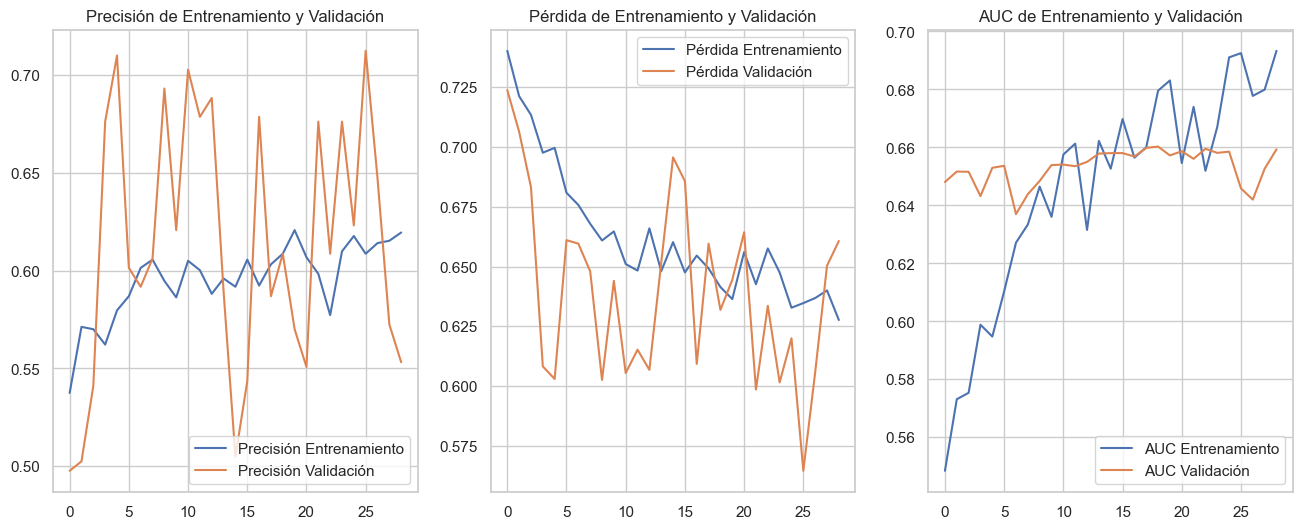

In [ ]:
# Evaluar el Modelo

# --- Graficar el historial de entrenamiento ---
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    auc = history.history.get('auc', []) # .get permite evitar error si 'auc' no está presente
    val_auc = history.history.get('val_auc', [])

    epochs_range = range(len(acc))

    plt.figure(figsize=(16, 6))
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, acc, label='Precisión Entrenamiento')
    plt.plot(epochs_range, val_acc, label='Precisión Validación')
    plt.legend(loc='lower right')
    plt.title('Precisión de Entrenamiento y Validación')

    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, loss, label='Pérdida Entrenamiento')
    plt.plot(epochs_range, val_loss, label='Pérdida Validación')
    plt.legend(loc='upper right')
    plt.title('Pérdida de Entrenamiento y Validación')

    if auc and val_auc:
        plt.subplot(1, 3, 3)
        plt.plot(epochs_range, auc, label='AUC Entrenamiento')
        plt.plot(epochs_range, val_auc, label='AUC Validación')
        plt.legend(loc='lower right')
        plt.title('AUC de Entrenamiento y Validación')

    plt.show()

plot_history(history)


Evaluando en los datos de validación...
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 406ms/step - accuracy: 0.6053 - auc: 0.6641 - loss: 0.6320
Pérdida en validación: 0.6319
Precisión en validación: 60.87%
AUC en validación: 0.6603
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 417ms/step

Reporte de Clasificación:
              precision    recall  f1-score   support

  Normal (0)       0.93      0.17      0.29       313
Glaucoma (1)       0.27      0.96      0.42       101

    accuracy                           0.36       414
   macro avg       0.60      0.56      0.36       414
weighted avg       0.77      0.36      0.32       414


Matriz de Confusión:


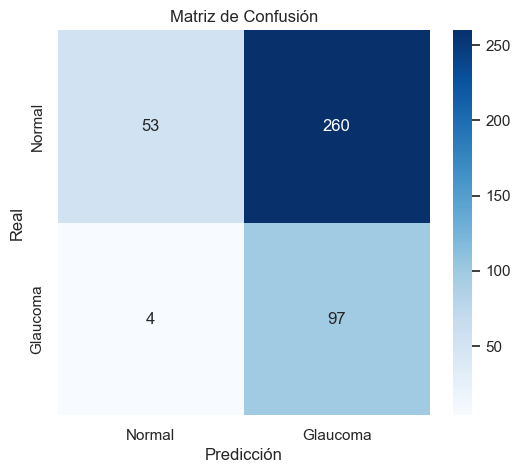

In [129]:
print("\nEvaluando en los datos de validación...")
results = model.evaluate(val_ds, verbose=1)
print(f"Pérdida en validación: {results[0]:.4f}")
print(f"Precisión en validación: {results[1]*100:.2f}%")
if len(results) > 2:
    print(f"AUC en validación: {results[2]:.4f}")

# Obtener predicciones para matriz de confusión e informe de clasificación
val_predictions_probs = model.predict(val_ds)

# Convertir probabilidades a predicciones binarias (umbral 0.3)
val_predictions = (val_predictions_probs > 0.3).astype(int).flatten()

# Los labels verdaderos ya están en val_labels, y el orden es correcto gracias a train_test_split.

print("\nReporte de Clasificación:")
print(classification_report(val_labels, val_predictions, target_names=['Normal (0)', 'Glaucoma (1)']))

print("\nMatriz de Confusión:")
cm = confusion_matrix(val_labels, val_predictions)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Glaucoma'],
            yticklabels=['Normal', 'Glaucoma'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()


In [130]:
# Hacer predicciones en un conjunto de imágenes individuales
def predict_single_image(image_path, model_to_use):
    img = load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_array_expanded)

    prediction_prob = model_to_use.predict(img_preprocessed)[0][0]
    prediction_class = "Glaucoma" if prediction_prob > 0.5 else "Normal"

    plt.imshow(img)
    plt.title(f"Prediction: {prediction_class} ({prediction_prob:.2f})")
    plt.axis("off")
    plt.show()
    return prediction_class, prediction_prob


--- Ejemplo de Predicciones ---

Predicción en la imagen 1 de 3:
Etiqueta real: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


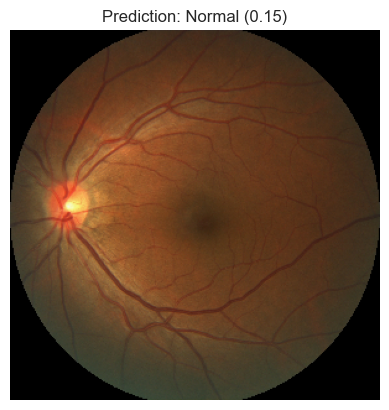


Predicción en la imagen 2 de 3:
Etiqueta real: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


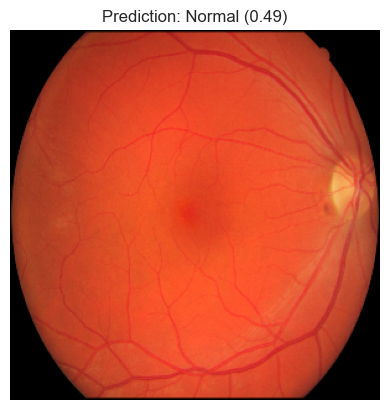


Predicción en la imagen 3 de 3:
Etiqueta real: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


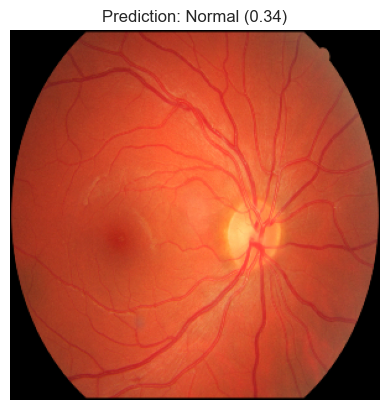

In [ ]:
import random

#Predecir en algunas imágenes de validación
print("\n--- Ejemplo de Predicciones ---")
if len(val_paths) >= 3:
    for i in range(3):
        random_index = random.randint(0, len(val_paths) - 1)
        print(f"\nPredicción en la imagen {i+1} de 3:")
        actual_label = "Glaucoma" if val_labels[random_index] == 1 else "Normal"
        print(f"Etiqueta real: {actual_label}")
        predict_single_image(val_paths[random_index], model) # Usa 'model' que debería tener los mejores (se fijó restore_best_weights = True en el entrenamiento)
else:
    print("No hay suficientes imágenes de validación para mostrar 3 ejemplos.")